# Calculate EOFs using the PCA module

In [1]:
# import modules
import pandas as pd
from sklearn.decomposition import PCA
import xarray as xr
import numpy as np
import pylab as plt
import re
import GPy as gp
import pylab as plt
import matplotlib.colors as colors

from pismemulator.utils import prepare_data

In [2]:
# Setup PCA

total_variance = 0.995
# Set up PCA such that enough components are calculated to explain at least the "total_variance"
pca = PCA(n_components=total_variance)

First we load the observed speeds

In [3]:
o_file = "../data/speeds/greenland_vel_mosaic250_v1_g1800m.nc"
o_xr = xr.open_dataset(o_file)

o_speed = o_xr.variables["velsurf_mag"].values
o_speed_sigma = o_xr.variables["velsurf_mag_error"].values

o_ny, o_nx = o_speed.shape
o_xr.close()

o_speeds = np.nan_to_num(o_speed, 0).reshape(-1, 1)
o_speeds_sigma = np.nan_to_num(o_speed_sigma, 0).reshape(-1, 1)

Second we load the raw files and create anomalies ourselves. Be careful to honor nans and removed them afterwards to get the same result as CDO.

In [5]:
from glob import glob
s_files = glob("../data/speeds/velsurf_mag_gris_g1800m_v3a_id_*_0_50.nc")
nt = len(s_files)

# open first file to get the dimensions
vxr0 = xr.open_dataset(s_files[0])
speed = vxr0.variables["velsurf_mag"].values
_, ny, nx = speed.shape
vxr0.close()

m_speeds = np.zeros((nt, ny * nx))

# Go through all files and don't forget to extract the experiment id
ids = []
for k, s_file in enumerate(s_files):
    print(f"Reading {s_file}")
    vxr = xr.open_dataset(s_file)
    ids.append(re.search("id_(.+?)_0", s_file).group(1))
    m_speeds[k, ::] = vxr.variables["velsurf_mag"].values.flatten()
    vxr.close()

# For comparison, we run the analysis for both u and log10(u)
m_speeds_mean = np.nanmean(m_speeds, axis=0)
m_speeds_anom = m_speeds - m_speeds_mean
m_speeds_anom = np.nan_to_num(m_speeds_anom, 0)

m_log_speeds = np.log10(np.nan_to_num(m_speeds, 0))
m_log_speeds[np.isneginf(m_log_speeds)] = 0
m_log_speeds_mean = np.nanmean(m_log_speeds, axis=0)
m_log_speeds_anom =  m_log_speeds - m_log_speeds_mean
m_log_speeds_anom[np.isneginf(m_log_speeds_anom)] = 0
m_log_speeds_anom = np.nan_to_num(m_log_speeds_anom, 0)

 <ipython-input-5-8f5418094829>:22: RuntimeWarning:Mean of empty slice
 <ipython-input-5-8f5418094829>:26: RuntimeWarning:divide by zero encountered in log10


Now run the PCA (fit to speeds)

In [7]:
m_pca = pca.fit(m_log_speeds_anom)

In [8]:
print(m_pca.n_components_)

679


## Eigenvalues

In the parlange of the PCA module,

`explained_variance_` are the `eigenvectors`
and
`components_` are the `eigenvalues` $e_j(t)$.

In [9]:
m_eigenvalues = m_pca.explained_variance_

## Eigenvectors

In [10]:
m_eigenvectors = m_pca.components_

## Coefficients

Calculate the coefficients $o_j(t)$, which are the dot product of the eigen vectors with the anomaly matrix according to
\begin{equation}
o_j(t) = \sum_{x=i}^p z(t,x) e_j(x)
\end{equation}

In [11]:
m_coefficients = np.dot(m_eigenvectors, m_speeds_anom.T)

Put coefficients in DataFrame and save to CSV.

In [13]:
response_file = "m_log_speed_coefficients.csv"
df = pd.DataFrame(data=m_coefficients.T[:,:], index=ids)
print(df.head())
df.to_csv(response_file, index_label="id")

               0             1              2             3             4    \
294  459422.443098  39681.988665  274884.851300 -24624.727556  31640.270770   
284  -69136.165605 -12505.197767  -43084.502505  22452.495590  -1910.502950   
913  -31116.856717  -1430.031287  -12944.004079 -14344.993513  -1438.153421   
903  -60079.450694 -15452.571566  -43184.316766  24194.157446  -1836.133313   
666  -49900.609637 -14955.018728  -42316.762756  26023.533990  -5665.751102   

              5              6             7              8              9    \
294 -44514.410151 -102180.546933 -27157.758418 -115466.451868 -144859.314136   
284   8521.766313   15936.120903   2311.605839   22077.844730   22270.742961   
913   -987.729925   16371.189542   3418.992894    1788.341364    3849.194171   
903   9557.541720   15724.113950   1591.629709   21994.138444   21703.113366   
666   9432.211562   14361.790335   2489.249636   22535.285924   21403.221938   

     ...          669          670          

Eigenglaciers

The first $n$ Eigenglaciers of ensemble member id=36 are:

Reconstruction with log-speeds


 <ipython-input-16-25a215154af2>:14: RuntimeWarning:overflow encountered in power


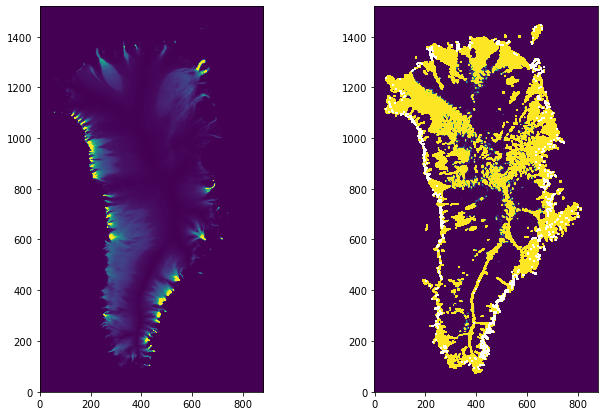

In [16]:
id = 36

n = m_pca.n_components_

reconstructed_speeds = m_log_speeds_mean.reshape(ny, nx)
for i in range(0, n):
    eigenglacier = (m_coefficients[i][id] * m_eigenvectors[i]).reshape(ny, nx)
    reconstructed_speeds += eigenglacier

print("Reconstruction with log-speeds")
fig, ax = plt.subplots(1, 2, sharex="col", figsize=[10, 120])
fig.subplots_adjust(hspace=0.05, wspace=0.5)
ax[0].imshow(m_speeds[id].reshape(ny, nx), origin="lower", cmap="viridis", vmin=0, vmax=500)
ax[1].imshow(10 ** reconstructed_speeds, origin="lower", cmap="viridis", vmin=0, vmax=500)


In [18]:
# Just some sanity check, making sure we understand the PCA module
lower_dimensional_data = m_pca.transform(m_speeds)
approximation = m_pca.inverse_transform(lower_dimensional_data)
# Add mean back to approximation
pca_reconstruction = approximation[id].reshape(ny, nx)
pca_reconstructed_speeds = pca_reconstruction + m_speeds_mean.reshape(ny, nx)

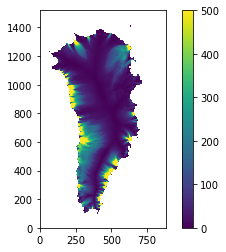

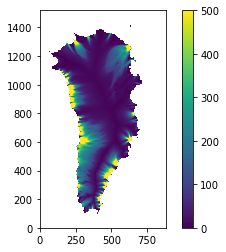

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
c = ax.imshow(m_speeds[id].reshape(ny, nx) + m_speeds_mean.reshape(ny, nx), origin="lower", cmap="viridis", vmin=0, vmax=500)
plt.colorbar(c)

fig = plt.figure()
ax = fig.add_subplot(111)
c = ax.imshow(pca_reconstructed_speeds, origin="lower", cmap="viridis", vmin=0, vmax=500)
plt.colorbar(c)

Read the samples and their responses (coefficients) for the log-speeds.

In [34]:
samples_file = "../data/samples/velocity_calibration_samples_100.csv"
samples, response = prepare_data(samples_file, log_response_file)



Preparing sample ../data/samples/velocity_calibration_samples_10.csv and response m_log_speed_coefficients.csv


In [35]:
X = samples.values
Y = response.values
n_dim = X.shape[1]

Read in the new samples that we want to emulate (an ensemble much larger than used for the high-fidelity model)

In [37]:
df = pd.read_csv("../data/samples/velocity_calibration_samples_100.csv", delimiter=",", squeeze=True, skipinitialspace=True)
X_new = df.values[:, 1::]

Now construct surrogate models for different covariance functions (kernels). Here we do this for the log-speeds because the optimized models have much smaller variances compared to the non-log speeds.

In [38]:
# Make a GP regression model

# Dictionary of GP kernels
gp_methods = {
    "rbf": gp.kern.RBF,
    "exp": gp.kern.Exponential,
    "expquad": gp.kern.ExpQuad,
    "mat32": gp.kern.Matern32,
    "mat52": gp.kern.Matern52,
}

models = {}
for key, kern in gp_methods.items():
    kernel = kern(input_dim=n_dim, ARD=True)
    m = gp.models.GPRegression(X, Y, kernel)
    f = m.optimize(messages=True)

    models[key] = m

 /Users/andy/Library/Python/3.8/lib/python/site-packages/GPy-1.9.9-py3.8-macosx-10.15-x86_64.egg/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/andy/Library/Python/3.8/lib/python/site-packages/GPy-1.9.9-py3.8-macosx-10.15-x86_64.egg/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/andy/Library/Python/3.8/lib/python/site-packages/GPy-1.9.9-py3.8-macosx-10.15-x86_64.egg/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


In [39]:
# Reconstruct emulated glaciers
# This is currently very slow

m = models["exp"]
p = m.predict(X_new)
m_log_coefficients_em = p[0]
ng = len(df)
m_log_speeds_em = np.zeros((ng, ny, nx))
print(m_log_coefficients.shape, m_log_eigenvectors.shape, ng, n_log)
for id in range(0, ng):
   print(f"Processing sample glacier {id}")
   reconstructed_speeds = m_log_speeds_mean.reshape(ny, nx)
   for i in range(0, n_log):
       eigenglacier = (m_log_coefficients_em[id][i] * m_log_eigenvectors[i]).reshape(ny, nx)
       reconstructed_speeds += eigenglacier
   m_log_speeds_em[id, :, :] = reconstructed_speeds
m_speeds_em = 10 ** m_log_speeds_em

(83, 100) (83, 1337600) 1000 83
Processing sample glacier 0
Processing sample glacier 1
Processing sample glacier 2
Processing sample glacier 3
Processing sample glacier 4
Processing sample glacier 5
Processing sample glacier 6
Processing sample glacier 7
Processing sample glacier 8
Processing sample glacier 9
Processing sample glacier 10
Processing sample glacier 11
Processing sample glacier 12
Processing sample glacier 13
Processing sample glacier 14
Processing sample glacier 15
Processing sample glacier 16
Processing sample glacier 17
Processing sample glacier 18
Processing sample glacier 19
Processing sample glacier 20
Processing sample glacier 21
Processing sample glacier 22
Processing sample glacier 23
Processing sample glacier 24
Processing sample glacier 25
Processing sample glacier 26
Processing sample glacier 27
Processing sample glacier 28
Processing sample glacier 29
Processing sample glacier 30
Processing sample glacier 31
Processing sample glacier 32
Processing sample gla

Processing sample glacier 276
Processing sample glacier 277
Processing sample glacier 278
Processing sample glacier 279
Processing sample glacier 280
Processing sample glacier 281
Processing sample glacier 282
Processing sample glacier 283
Processing sample glacier 284
Processing sample glacier 285
Processing sample glacier 286
Processing sample glacier 287
Processing sample glacier 288
Processing sample glacier 289
Processing sample glacier 290
Processing sample glacier 291
Processing sample glacier 292
Processing sample glacier 293
Processing sample glacier 294
Processing sample glacier 295
Processing sample glacier 296
Processing sample glacier 297
Processing sample glacier 298
Processing sample glacier 299
Processing sample glacier 300
Processing sample glacier 301
Processing sample glacier 302
Processing sample glacier 303
Processing sample glacier 304
Processing sample glacier 305
Processing sample glacier 306
Processing sample glacier 307
Processing sample glacier 308
Processing

Processing sample glacier 550
Processing sample glacier 551
Processing sample glacier 552
Processing sample glacier 553
Processing sample glacier 554
Processing sample glacier 555
Processing sample glacier 556
Processing sample glacier 557
Processing sample glacier 558
Processing sample glacier 559
Processing sample glacier 560
Processing sample glacier 561
Processing sample glacier 562
Processing sample glacier 563
Processing sample glacier 564
Processing sample glacier 565
Processing sample glacier 566
Processing sample glacier 567
Processing sample glacier 568
Processing sample glacier 569
Processing sample glacier 570
Processing sample glacier 571
Processing sample glacier 572
Processing sample glacier 573
Processing sample glacier 574
Processing sample glacier 575
Processing sample glacier 576
Processing sample glacier 577
Processing sample glacier 578
Processing sample glacier 579
Processing sample glacier 580
Processing sample glacier 581
Processing sample glacier 582
Processing

Processing sample glacier 824
Processing sample glacier 825
Processing sample glacier 826
Processing sample glacier 827
Processing sample glacier 828
Processing sample glacier 829
Processing sample glacier 830
Processing sample glacier 831
Processing sample glacier 832
Processing sample glacier 833
Processing sample glacier 834
Processing sample glacier 835
Processing sample glacier 836
Processing sample glacier 837
Processing sample glacier 838
Processing sample glacier 839
Processing sample glacier 840
Processing sample glacier 841
Processing sample glacier 842
Processing sample glacier 843
Processing sample glacier 844
Processing sample glacier 845
Processing sample glacier 846
Processing sample glacier 847
Processing sample glacier 848
Processing sample glacier 849
Processing sample glacier 850
Processing sample glacier 851
Processing sample glacier 852
Processing sample glacier 853
Processing sample glacier 854
Processing sample glacier 855
Processing sample glacier 856
Processing

Generate a GP model with an exponential kernel (Eq 54)

In [44]:
kernel = gp_methods["exp"](input_dim=n_dim, ARD=True)

What is the residual function $r(x)$ in Eq. 55

In [45]:
# np.linalg.norm(m_log_speeds, axis=0) is not G(x,m,w)
# Do I do this with log(U) or U?

R = np.array(np.linalg.norm(m_speeds_em.reshape(ng, -1), axis=1) - np.linalg.norm(o_speeds)).reshape(-1, 1)
# Here we need to add the noise variance which is the observational variance via noise_var=...
m = gp.models.GPRegression(X_new, R, kernel, noise_var=np.var(o_speeds_sigma))

In [46]:
hmc = gp.inference.mcmc.HMC(m, stepsize=5e-2)
s = hmc.sample(num_samples=1000) # Burnin
s = hmc.sample(num_samples=1000)

 /Users/andy/Library/Python/3.8/lib/python/site-packages/paramz-0.9.5-py3.8.egg/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/andy/Library/Python/3.8/lib/python/site-packages/paramz-0.9.5-py3.8.egg/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/andy/Library/Python/3.8/lib/python/site-packages/paramz-0.9.5-py3.8.egg/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater
 /Users/andy/Library/Python/3.8/lib/python/site-packages/paramz-0.9.5-py3.8.egg/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


Reconstruction with log-speeds


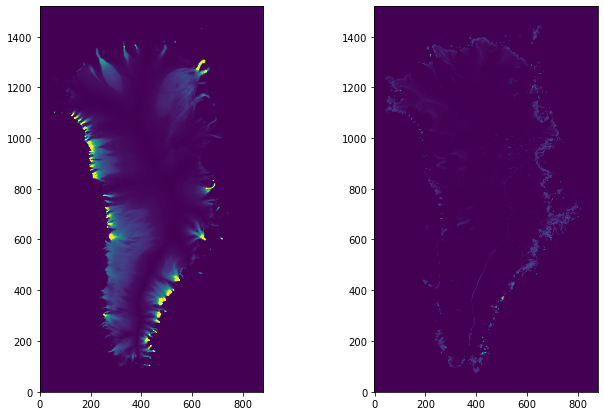

In [17]:
print("Reconstruction with log-speeds")
fig, ax = plt.subplots(1, 2, sharex="col", figsize=[10, 120])
fig.subplots_adjust(hspace=0.05, wspace=0.5)
ax[0].imshow(m_speeds[id].reshape(ny, nx), origin="lower", cmap="viridis", vmin=0, vmax=500)
ax[1].imshow(reconstructed_speeds, origin="lower", cmap="viridis", vmin=0, vmax=500)

